# Compute LST and NDVI in NYC for Landsat 5

## Introduction 

In this notebook, we compute LST for the New York City using *Landsat 5* data that is clipped to NYC boundaries. (Another notebook is used to compute LST with Landsat 8 data.) To compute LST, we follow the procedure outlined in Using McConnell's 2022 paper. The steps are 

- Convert Band 6 to Top of Atmosphere (TOA) spectral radiance using two constants from Landsat metadata
- Compute brightness temperature using TOA and 2 constants from metadata
- Compute NDVI using 
\begin{align}
\frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}} = \frac{\text{Band} \, 4 \, – \text{Band} \, 3}{\text{Band} \, 4 + \text{Band} \, 3} 
\end{align}
- Convert NDVI to vegetation fraction
- Compute emissivity using the formula specified in McConnell's paper
- Compute LST using brightness temperature, emissivity, and some constants also specified in McConnell's paper

The contents of this notebook are the following.

- In [Section 1](#import), we define functions to compute the outlined procedure
- In [Section 2](#test) we test the procedure on a single Landsat file and plot the result. 
- In [Section 3](#export) we compute LST and NDVI for all the Landsat files and export results. 

## Results

LST and NDVI are computed in this notebook and exported for later use. A heatmap of LST/NDVI can be generated in [Section 2](#test).

## Data

The data imported into this notebook is clipped Landsat data located in `02-data/landsat_clipped_nyc/`. These are raster files saved in `.tif` format. We import the files relevant to LST calculations with Landsat 5, which are bands 3, 4, and 6. 

Data is exported to the folders `02-data/ndvi_clipped_nyc` and `02-data/lst_clipped_nyc`. The exported filenames contain the parameter computed with the original Landsat filename. For example, the file `ndvi_LT05_L1TP_013032_19910801_20160929_01_T1.tif` contains the NDVI calculation in NYC for the Landsat file listed. 

In [1]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push the directory to load helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import rioxarray as rxr
import xarray as xr
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# Import directories
DIR_DATA = DIR_PARENT + "/02-data"
DIR_RAW_CLIPPED_NYC = DIR_PARENT + "/02-data/landsat_clipped_nyc"

# Export directories
DIR_NDVI_CLIPPED_NYC = DIR_PARENT + "/02-data/ndvi_clipped_nyc"
DIR_LST_CLIPPED_NYC = DIR_PARENT + "/02-data/lst_clipped_nyc"
DIR_FIGS = DIR_PARENT + "/03-figs"

## 1. Import data and define functions <a id="import"></a>

In [2]:
landsat_filenames = []
helpers.get_filenames(DIR_RAW_CLIPPED_NYC, landsat_filenames)
landsat_filenames.sort()

# Filter clipped Landsat files by band
band3_filenames = [x for x in landsat_filenames if ("B3" in x and "LT05" in x)]
band4_filenames = [x for x in landsat_filenames if ("B4" in x and "LT05" in x)]
band6_filenames = [x for x in landsat_filenames if ("B6" in x and "LT05" in x)]

band3_filenames.sort()
band4_filenames.sort()
band6_filenames.sort()

print("Number of B3 files = ", len(band3_filenames))
print("Number of B4 files = ", len(band4_filenames))
print("Number of B6 files = ", len(band6_filenames))

def get_original_landsat_name(name):
    return "_".join(name.split("/")[-1].split(".")[0].split("_")[2:-1])

def import_txt_as_dict(name):
    d = {}
    with open(name) as f:
        for line in f:
            if len(line.split("="))>1:
                (key, val) = line.split("=")
                d[key] = val.split("\n")[0]
    return d

def open_mtl_file(landsat_filename):
    dirname = "/".join(landsat_filename.split("/")[:-1])
    fileroot = get_original_landsat_name(landsat_filename)
    return import_txt_as_dict(dirname+"/"+fileroot+"_MTL"+".txt")

def open_masked_band(filename, mask_value):    
    band = rxr.open_rasterio(filename)
    data_xarray = xr.DataArray(np.ma.masked_where(band==mask_value, \
                                                  band).squeeze(),
        dims=["y","x"],
        coords={"x":band["x"].data,
               "y":band["y"].data,
               "band":1,
               "spatial_ref":0},
        attrs=band.attrs)
    data_xarray.rio.write_crs(band.rio.crs, inplace=True)
    return data_xarray

def compute_toa_radiance(band, meta):
    Ml = float(meta["    RADIANCE_MULT_BAND_6 "])
    Al = float(meta["    RADIANCE_ADD_BAND_6 "])
    return Ml*band + Al

def compute_brightness_temp(toa, meta):
    K1 = float(meta["    K1_CONSTANT_BAND_6 "])
    K2 = float(meta["    K2_CONSTANT_BAND_6 "])
    return K2/np.log(K1/toa + 1)

def compute_ndvi(nir, red, meta):
    nir_toa = compute_toa_radiance(nir, meta)
    red_toa = compute_toa_radiance(red, meta)
    return (nir_toa-red_toa)/(nir_toa+red_toa)

def compute_vegetation_fraction(ndvi):
    ndvi_min = np.min(ndvi)
    ndvi_max = np.max(ndvi)
    return (ndvi-ndvi_min/(ndvi_max-ndvi_min))**2

def compute_emissivity(p):
    return 0.004*p + 0.986481

def compute_lst(w, bt, emiss):
    Q = 1.438*10**(-2)
    return bt/(1 + w*bt*np.log(emiss)/Q)

Number of B3 files =  92
Number of B4 files =  92
Number of B6 files =  92


## 2. Test the computation for a single date <a id="test"></a>

In [5]:
"""Test the program by selecting a single file"""
select = 90 # OPTIONS: Integer between 0 and (Number of Landsat files) - 1.

# Open band 6 and its metadata file
band6_test = open_masked_band(band6_filenames[select], 0.0)
mtl_test = open_mtl_file(band6_filenames[select])

# Open nir and red
band4_test = open_masked_band(band4_filenames[select], 0.0)
band3_test = open_masked_band(band3_filenames[select], 0.0)

print(band3_filenames[select])
print(band4_filenames[select])
print(band6_filenames[select])

# Begin LST equations
toa = compute_toa_radiance(band6_test, mtl_test)
bt = compute_brightness_temp(toa, mtl_test)

ndvi = compute_ndvi(band4_test, band3_test, mtl_test)

vf = compute_vegetation_fraction(ndvi)
emiss = compute_emissivity(vf)
w = 11.45*10**-6 # From USGS, Band 6 wavelengths = 10.40 - 12.50 µm
lst = compute_lst(w, bt, emiss)

exportname_lst = DIR_LST_CLIPPED_NYC + "/lst_" + \
    get_original_landsat_name(band6_filenames[select])
exportname_ndvi = DIR_NDVI_CLIPPED_NYC + "/ndvi_" + \
    get_original_landsat_name(band6_filenames[select])

# Test export #####################################################
# NOTE: Running this will overwrite any data already exported
# lst.rio.to_raster(exportname_lst, driver="GTiff")
# ndvi.rio.to_raster(exportname_ndvi, driver="GTiff")

/home/aderrasc/Documents/japa_final/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_014032_20110831_20160831_01_T1_B3.TIF
/home/aderrasc/Documents/japa_final/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_014032_20110831_20160831_01_T1_B4.TIF
/home/aderrasc/Documents/japa_final/02-data/landsat_clipped_nyc/clipped_nyc_LT05_L1TP_014032_20110831_20160831_01_T1_B6.TIF


#### Plot results

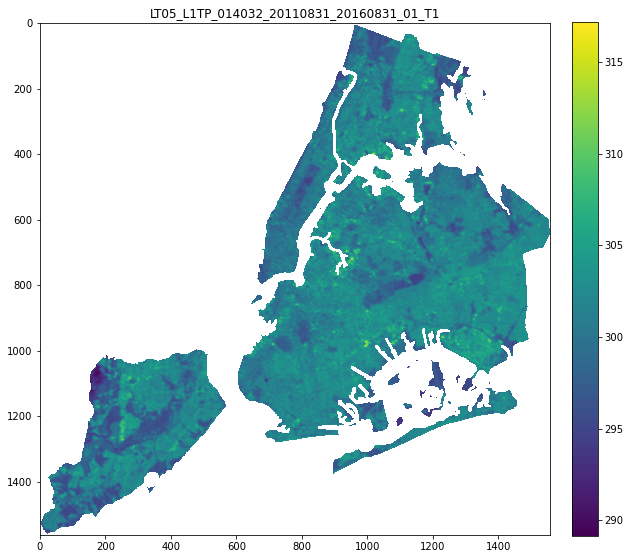

In [6]:
# Plot the test band
object_to_plot = lst # OPTIONS: lst, ndvi, bandX_test, toa, bt, vf, emiss
##########################################################################
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(object_to_plot)#, cmap="RdYlBu")#,vmin=-1,vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title(get_original_landsat_name(band6_filenames[select]))
plt.savefig(DIR_FIGS + "/lst_"+get_original_landsat_name(\
                                        band6_filenames[select]) + ".png")
plt.show()

## 3. Export LST and NDVI for all dates <a id="export"></a>

In [10]:
for index in range(len(band6_filenames)):
    # Open bands and metadata file
    band6 = open_masked_band(band6_filenames[index], 0.0)
    band4 = open_masked_band(band4_filenames[index], 0.0)
    band3 = open_masked_band(band3_filenames[index], 0.0)
    mtl = open_mtl_file(band6_filenames[index])

    # Begin LST equations
    toa = compute_toa_radiance(band6, mtl)
    bt = compute_brightness_temp(toa, mtl)
    ndvi = compute_ndvi(band4, band3, mtl)
    vf = compute_vegetation_fraction(ndvi)
    emiss = compute_emissivity(vf)
    w = 11.45*10**-6 # Center of Band 6 = 10.40 - 12.50 µm
    lst = compute_lst(w, bt, emiss)

    suffix = get_original_landsat_name(band6_filenames[index]) + ".tif"
    exportname_lst = DIR_LST_CLIPPED_NYC + "/lst_" + suffix
    exportname_ndvi = DIR_NDVI_CLIPPED_NYC + "/ndvi_" + suffix

    print("Saving ", suffix)
    lst.rio.to_raster(exportname_lst, driver="GTiff")
    ndvi.rio.to_raster(exportname_ndvi, driver="GTiff")    

Saving  LT05_L1TP_013032_19850901_20161004_01_T1.tif
Saving  LT05_L1TP_013032_19850917_20161004_01_T1.tif
Saving  LT05_L1TP_013032_19880621_20161002_01_T1.tif
Saving  LT05_L1TP_013032_19880808_20161002_01_T1.tif
Saving  LT05_L1TP_013032_19890726_20161002_01_T1.tif
Saving  LT05_L1TP_013032_19900830_20161001_01_T1.tif
Saving  LT05_L1TP_013032_19910716_20160929_01_T1.tif
Saving  LT05_L1TP_013032_19910801_20160929_01_T1.tif
Saving  LT05_L1TP_013032_19910817_20160929_01_T1.tif
Saving  LT05_L1TP_013032_19910902_20161001_01_T1.tif
Saving  LT05_L1TP_013032_19920920_20160929_01_T1.tif
Saving  LT05_L1TP_013032_19940622_20160927_01_T1.tif
Saving  LT05_L1TP_013032_19940708_20160927_01_T1.tif
Saving  LT05_L1TP_013032_19940809_20160927_01_T1.tif
Saving  LT05_L1TP_013032_19940825_20160927_01_T1.tif
Saving  LT05_L1TP_013032_19940910_20160927_01_T1.tif
Saving  LT05_L1TP_013032_19950727_20160927_01_T1.tif
Saving  LT05_L1TP_013032_19960627_20160924_01_T1.tif
Saving  LT05_L1TP_013032_19960830_20160924_01_